# Laboratorium

### Konfiguracja

In [2]:
#biblioteki które importuje ja
import random
import pandas as pd
import math

# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [3]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Rysowanie prostego rysunku złożonego ze statycznych punktów i odcinków jest stosunkowo proste. Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje w konstruktorze listę obiektów `PointsCollection` jako parametr `points` oraz listę `LinesCollection` jako parametr `lines`. Następnie należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


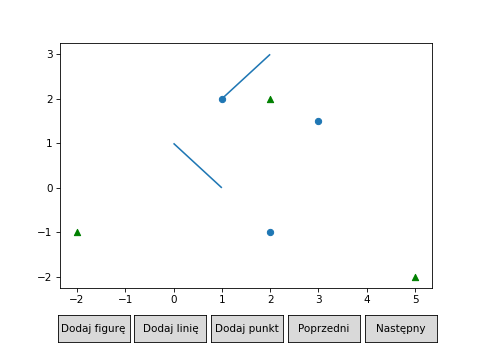

In [4]:
%matplotlib notebook

plot = Plot(points=[PointsCollection([(1, 2), (3, 1.5), (2, -1)]),
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")],
            lines=[LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])
plot.draw()

##### Rysunek dynamiczny

To narzędzie pozwala na wizualizację "rysunków dynamicznych", a więc takich, które składają się z wielu różnych obrazów. Może to być przydatne np. podczas wizualizacji kolejnych kroków danego algorytmu. Poszczególne klatki określane są jako obiekty `Scene`, które przyjmują listę `PointsCollection` oraz listę `LinesCollection` w swoim konstruktorze. Obiekt `Plot` przyjmuje w parametrze konstruktora `scenes` właśnie listę takich scen.

Na rysunku przyciski `Następny` i `Poprzedni` służą do nawigacji pomiędzy nimi.

<IPython.core.display.Javascript object>


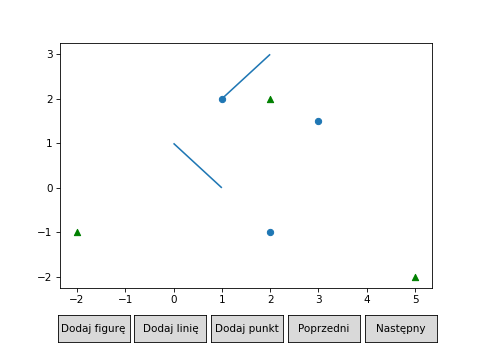

In [5]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot=Plot(scenes = scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


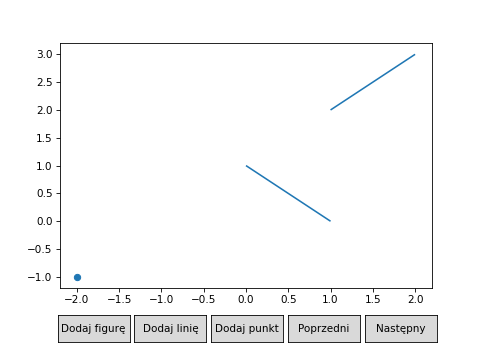

In [6]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.json: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


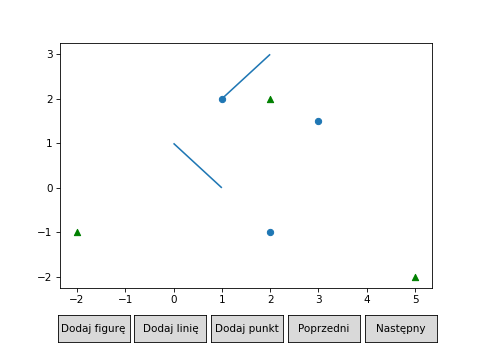

In [7]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


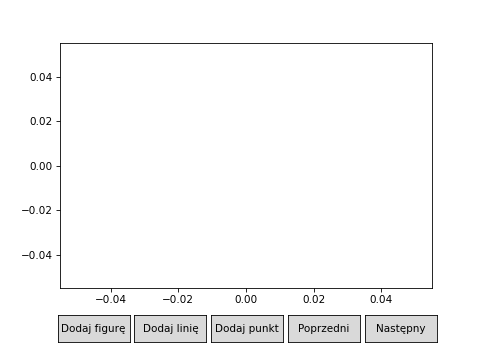

In [8]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

# Rozwiązanie

### Generowanie zbiorów i ich wizualizacja

W tej komórce  odbywa się generacja punktów które będą 
wykorzystane do analizy w dalszym etapie eksperymentu

In [9]:
#tworzenie zbiorów
A=[(random.randint(-1000,1000),random.uniform(-1000,1000)) for _ in range(10**5)]
B=[(random.randint(-(10**14),(10**14)),random.uniform(-(10**14),(10**14))) for _ in range(10**5)]
C=[(math.cos(math.pi*2* _)*100,math.sin(math.pi*2*_)*100) for _ in [random.uniform(0,1) for i in range(1000)]]
#wektor normalny [2,0.1]
D =[(2.0*i,0.1*i) for i in [random.uniform(-500,500) for _ in range(1000)]]
def punkty_na_prostej(point_1,point_2,n):
    dy = point_2[1] - point_1[1]
    dx = point_2[0] - point_1[0]
    a = dy/dx
    b = point_1[1] - a * point_1[0]
    def prosta(x):
        return a*x+b
    res = []
    for i in [random.uniform(-500,500) for _ in range(1000)]:
        res.append((i, prosta(i)))
    return res
Dprim = punkty_na_prostej((-1,0),(1,0.1),(1000))




Wizualalizacja każdego z wygenerowanych wyżej zbiorów punktów

### Zbiór A

<IPython.core.display.Javascript object>


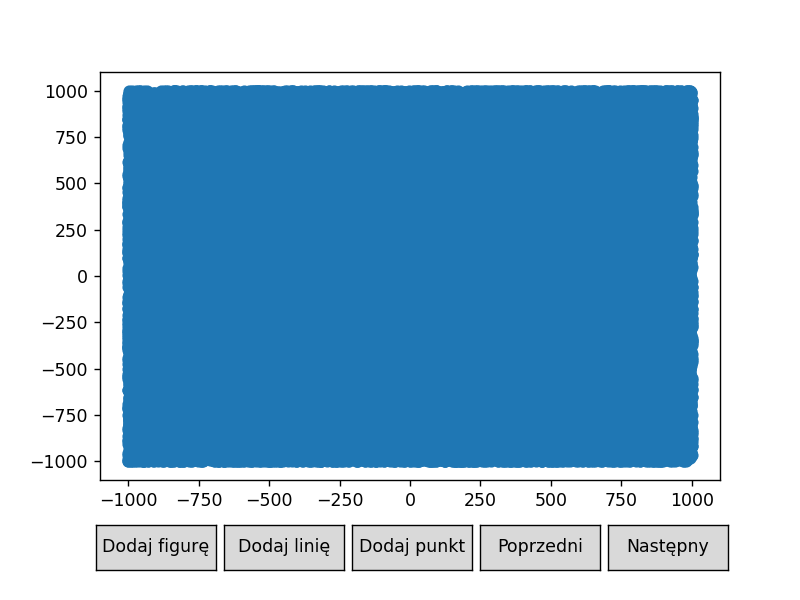

In [9]:
zbiorAwiz=Plot(points=[PointsCollection(A)])
zbiorAwiz.draw()

### Zbiór B

<IPython.core.display.Javascript object>


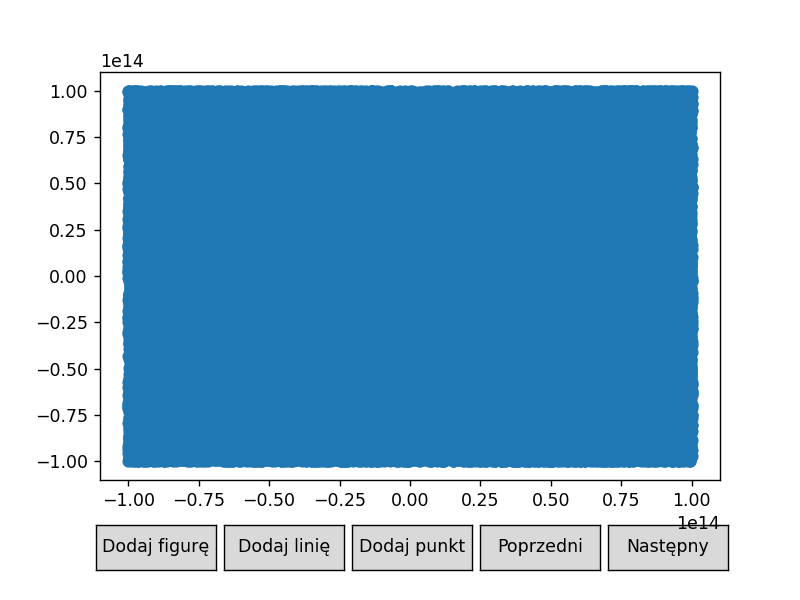

In [10]:
zbiorBwiz=Plot(points=[PointsCollection(B)])
zbiorBwiz.draw()

### Zbiór C

<IPython.core.display.Javascript object>


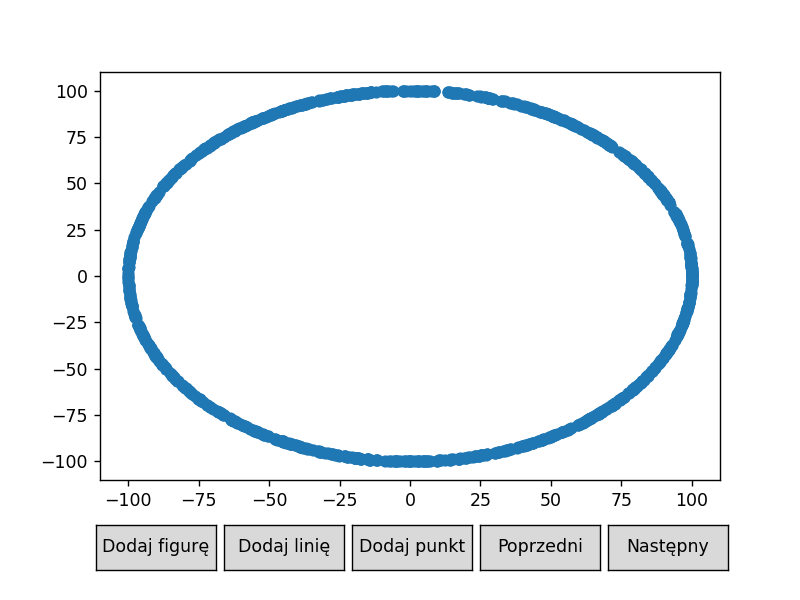

In [11]:
zbiorCwiz=Plot(points=[PointsCollection(C)])
zbiorCwiz.draw()

### Zbiór D metoda wektor normalny

<IPython.core.display.Javascript object>


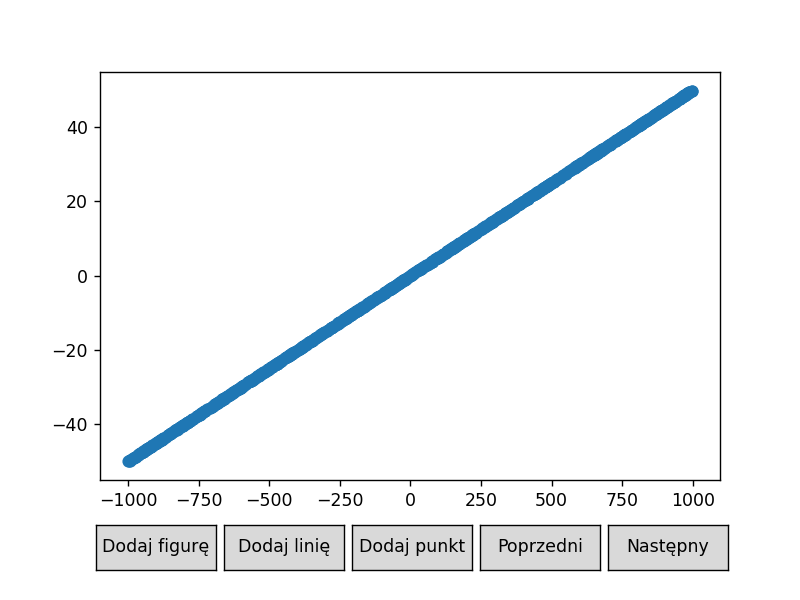

In [12]:
zbiorDwiz=Plot(points=[PointsCollection(D)])
zbiorDwiz.draw()

### Zbiór D generowany jako funkcja liniowa

<IPython.core.display.Javascript object>


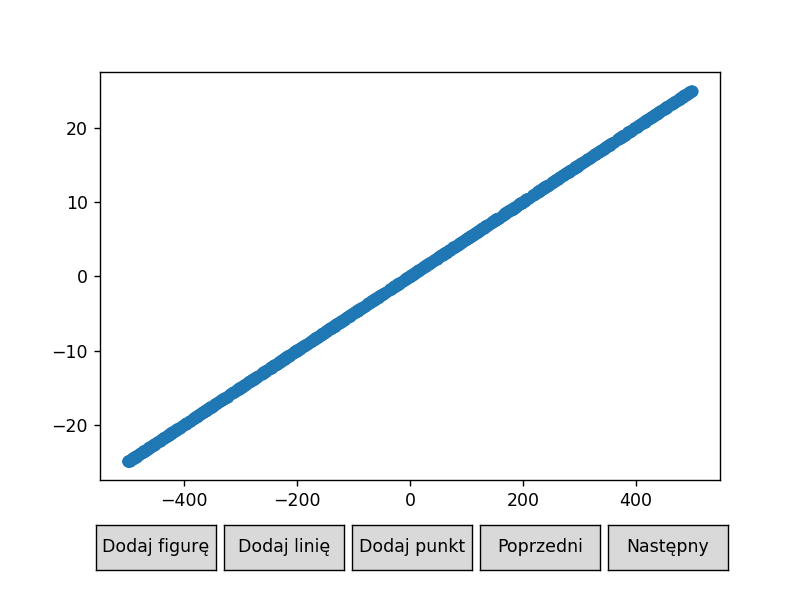

In [13]:
zbiorDwizprim=Plot(points=[PointsCollection(Dprim)])
zbiorDwizprim.draw()

### Segregacja punktów względem odcinka  ab gdzie  a = [-1.0,  0.0],  b= [1.0,  0.1] 

 Do podzelenia punktów potrzebne będzie kilka funkcji: <br>
-funkcja tworząca macierz z przekazanych punktów w formaciw 3x3 <br>
-funkcja tworząca macierz z przekazanych punktów w formaciw 2x2 <br>
-funkcje obliczające wyznaczniki macierzy 2x2 i 3x3 <br>
-gotowa funkcja sortująca <br>
Funkcje te zostaną zadeklarowane poniżej:



In [10]:
#tworzenie macierzy 3x3
def matrix_3x3(pointA,pointB,pointC):
    result = np.array([[pointA[0],pointA[1],1],
                      [pointB[0],pointB[1],1],
                      [pointC[0],pointC[1],1]])
    return result
#obliczanie wyznacznika 3x3
def det_3x3(matrix):
    return ((matrix[0][0]*matrix[1][1]*matrix[2][2]+
            matrix[0][1]*matrix[1][2]*matrix[2][0]+
            matrix[0][2]*matrix[1][0]*matrix[2][1])
            -(matrix[0][2]*matrix[1][1]*matrix[2][0]+
            matrix[0][0]*matrix[1][2]*matrix[2][1]+
            matrix[0][1]*matrix[1][0]*matrix[2][2]))

#tworzenie macierzy 2x2
def matrix_2x2(pointA,pointB,pointC):
    result = np.array([[pointA[0]-pointC[0],pointA[1]-pointC[1]],
                       [pointB[0]-pointC[0],pointB[1]-pointC[1]]])
    return result
#obliczanie wyznacznika 2x2
def det_2x2(matrix):
    return matrix[0][0]*matrix[1][1]-matrix[0][1]*matrix[1][0]
#sortowanie punktów względem prostej przy użyciu wybranej macierzy
def points_sorting(pointsList,line,epsilon,matrix_type,determin):
    pointsListC=pointsList[:]
    left = []
    right = []
    cLinear = []
    for id,i in enumerate(pointsList):
        matrix = matrix_type(line[0],line[1],i)
        det = determin(matrix)
        #print('wyznacznik jest równy:',det," a z mojego ",det_33(matrix))
        if det < -epsilon:      
            right.append(i)
            pointsListC[id]=(i[0],i[1],'R')
        elif det > epsilon:
            left.append(i)
            pointsListC[id]=(i[0],i[1],'L')
        else:
            cLinear.append(i)
            pointsListC[id]=(i[0],i[1],'C')
    return (left,right,cLinear,pointsListC)
#zwizualizowanie rezultatów sortowania wraz z opisem
def sorted_points_print(pointsList,line,epsilon):
    data=[]
    scenes=[]
    #możliwe parametry uruchomienia ze względu na typ macierzy i rodzaj użytego wyznacznika
    matrix_type=[(matrix_3x3,det_3x3),(matrix_3x3,np.linalg.det),(matrix_2x2,det_2x2),(matrix_2x2,np.linalg.det)]
    dif = 0
    dif_points = set()
    for prec in epsilon:
        difference = []
        for configuration in matrix_type:
            result = points_sorting(pointsList,line,prec,*configuration)
            difference.append(result[3])
            points = [PointsCollection(result[0],color="yellow",marker="."),
                      PointsCollection(result[1],color="red",marker="."),
                      PointsCollection(result[2],color="green",marker=".")]
            scenes.append(points)
            data.append([configuration[0].__name__,("det from np" if configuration[1].__name__ == "det" else configuration[1].__name__),prec,len(result[0]),len(result[1]),len(result[2])])
        
        for i in zip (difference[0],difference[1],difference[2],difference[3]):
            if i[0] == i[1] == i[2] == i[3]:
                pass
            else:
                dif_points.add((i[0][0],i[0][1]))
                dif+=1
    pd.DataFrame(data,columns=["matrix type","det type","prec","Left","Right","Colinear"])
    return data,scenes,dif,dif_points


## segregowanie  zbioru A

In [43]:
data,scenes,dif,dif_points=sorted_points_print(A,[[-1,0],[1,0.1]],[1e-10,1e-11,1e-12,1e-13,1e-14])
pd.DataFrame(data,columns=["matrix_type","det_type","prec","Left","Right","Colinear"])

,matrix_type,det_type,prec,Left,Right,Colinear
0,matrix_3x3,det_3x3,1.000000e-10,49983,50017,0
1,matrix_3x3,det from np,1.000000e-10,49983,50017,0
2,matrix_2x2,det_2x2,1.000000e-10,49983,50017,0
3,matrix_2x2,det from np,1.000000e-10,49983,50017,0
4,matrix_3x3,det_3x3,1.000000e-11,49983,50017,0
5,matrix_3x3,det from np,1.000000e-11,49983,50017,0
6,matrix_2x2,det_2x2,1.000000e-11,49983,50017,0
7,matrix_2x2,det from np,1.000000e-11,49983,50017,0
8,matrix_3x3,det_3x3,1.000000e-12,49983,50017,0
9,matrix_3x3,det from np,1.000000e-12,49983,50017,0


Punkty sklasywfikowane inaczej dla tej samej precyzji ale dla różnych metod

In [16]:
print(dif)

0


Poniżej na każdej scenie znajduje się wynik kolejnych rezultatów z tebeli wyżej. <br>
kolor żółty oznacza punkty na lewo od odcinka, czerwony na prawo, a zielony punkty współ liniowe.

<IPython.core.display.Javascript object>


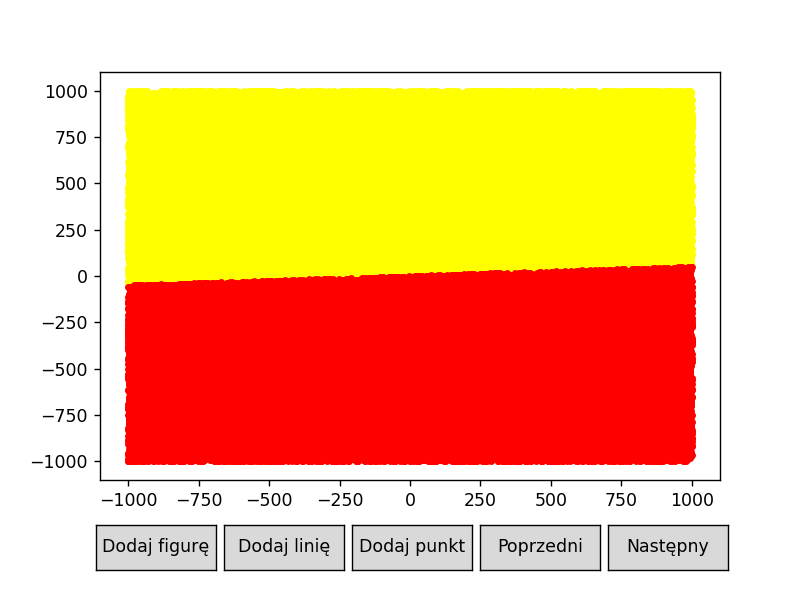

In [17]:
scenes_r=[Scene(i) for i in scenes]
zbiorAsorted=Plot(scenes = scenes_r)
zbiorAsorted.draw()

### Wnioski
Nie zależnie od użytej metody (macierz 3x3 lub 2x2) oraz niezależnie od wykorzystanej metody obliczania wyznacznika(własna implementacja/funkcja biblioteczna) dla określonej precyzji otrzymujemy te same wyniki dla punktów ze zbioru A.

## Segregowanie  zbioru B
Forma przedstawienia rezultatów sortowania analogiczna jak wyżej

In [68]:
data,scenes,dif,dif_points=sorted_points_print(B,[[-1,0],[1,0.1]],[1e-10,1e-11,1e-12,1e-13,1e-14])
pd.DataFrame(data,columns=["matrix_type","det_type","prec","Left","Right","Colinear"])

,matrix_type,det_type,prec,Left,Right,Colinear
0,matrix_3x3,det_3x3,1.000000e-10,49711,50289,0
1,matrix_3x3,det from np,1.000000e-10,49711,50289,0
2,matrix_2x2,det_2x2,1.000000e-10,49705,50286,9
3,matrix_2x2,det from np,1.000000e-10,49711,50289,0
4,matrix_3x3,det_3x3,1.000000e-11,49711,50289,0
5,matrix_3x3,det from np,1.000000e-11,49711,50289,0
6,matrix_2x2,det_2x2,1.000000e-11,49705,50286,9
7,matrix_2x2,det from np,1.000000e-11,49711,50289,0
8,matrix_3x3,det_3x3,1.000000e-12,49711,50289,0
9,matrix_3x3,det from np,1.000000e-12,49711,50289,0


<IPython.core.display.Javascript object>


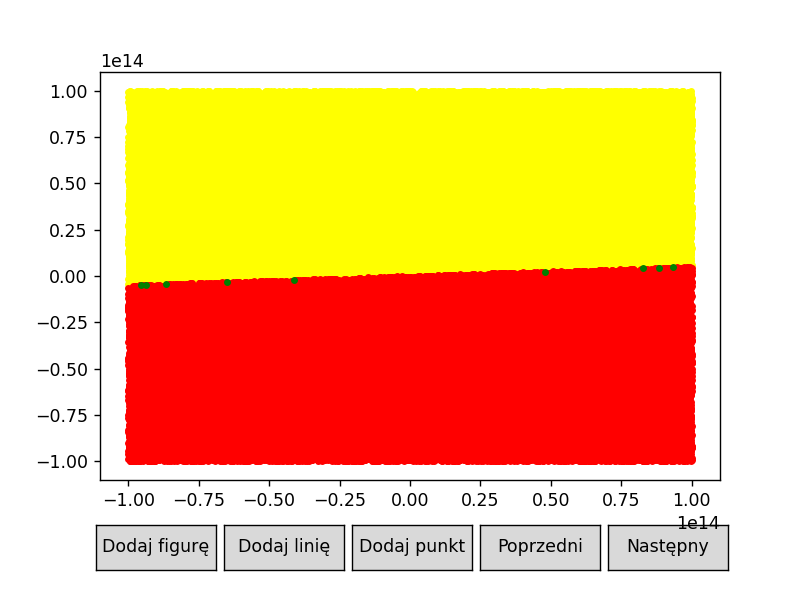

In [52]:
scenes_r=[Scene(i) for i in scenes]
zbiorBsorted=Plot(scenes = scenes_r)
zbiorBsorted.draw()

Wypisanie liczby przypadków kiedy nastąpiły rozbierzności pomiędzy metodami,
liczba źle sklasyfikowanych punktów,wypisanie rzeczonych punktów

In [70]:
print(dif)
print(len(dif_points))
print(dif_points)

45
9
{(88457782119615, 4396977466483.0938), (48075241724910, 2404292042187.078), (82567852186839, 4145679217135.9375), (-93730072655224, -4690470237443.203), (-95417042558626, -4756363340145.75), (-86569010407865, -4326713265264.0156), (93417952407604, 4672971797506.359), (-64765780792162, -3234694585045.078), (-41137365236843, -2057455544329.25)}


### Wnioski
Jak się okazuje dla punktów z współżędnymi z zakresu (-10^14,10^14), występuje anomalia dla metody wykorzysującej macierz 2x2 i wyznacznik obliczany samodzielnie zaimplementowaną funkcją.

## Segregacja zbioru C

In [71]:
data,scenes,dif,dif_points=sorted_points_print(C,[[-1,0],[1,0.1]],[1e-10,1e-11,1e-12,1e-13,1e-14])
pd.DataFrame(data,columns=["matrix_type","det_type","prec","Left","Right","Colinear"])

,matrix_type,det_type,prec,Left,Right,Colinear
0,matrix_3x3,det_3x3,1.000000e-10,510,490,0
1,matrix_3x3,det from np,1.000000e-10,510,490,0
2,matrix_2x2,det_2x2,1.000000e-10,510,490,0
3,matrix_2x2,det from np,1.000000e-10,510,490,0
4,matrix_3x3,det_3x3,1.000000e-11,510,490,0
5,matrix_3x3,det from np,1.000000e-11,510,490,0
6,matrix_2x2,det_2x2,1.000000e-11,510,490,0
7,matrix_2x2,det from np,1.000000e-11,510,490,0
8,matrix_3x3,det_3x3,1.000000e-12,510,490,0
9,matrix_3x3,det from np,1.000000e-12,510,490,0


<IPython.core.display.Javascript object>


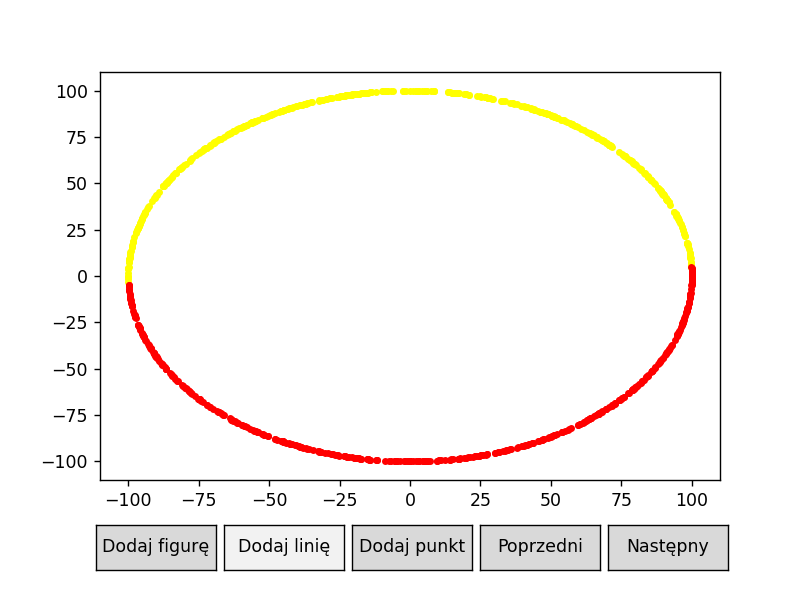

In [22]:
scenes_r=[Scene(i) for i in scenes]
zbiorCsorted=Plot(scenes = scenes_r)
zbiorCsorted.draw()

In [23]:
print(dif)

0


# Wnioski
Punkty rozłożone są na okręgu o promieniu 100 ,klasyfikacja punktów
nie daje rezultatów które wskazuwałyby na współliniowość jakich kolwiek punktów niezależnie od obranej macierzy i metody obliczania wyznacznika.

## Segregacja zbioru D

Punkty w tym zbiorze są wygenerowane na prostej współliniowej z obranym przez nas do analizy odcinkiem i mają współżędne maksymalne rzędu 1e3, dlatego obrana w tym wypadku precyzja obliczeń powinna być więkrza.(na postawie obserwacji w poprzednich zbiorach)

Jako druga metoda wygenerowania tego zbioru, wykorzystana zostsała funkcja liniowa. Poniżej wyniki tej metody generacji zbioru.

In [13]:
data,scenes,dif,dif_points=sorted_points_print(Dprim,[[-1,0],[1,0.1]],[1e-10,1e-11,1e-12,1e-13,1e-14,1e-15,1e-16,1e-17,1e-18])
pd.DataFrame(data,columns=["matrix_type","det_type","prec","Left","Right","Colinear"])

,matrix_type,det_type,prec,Left,Right,Colinear
0,matrix_3x3,det_3x3,1.000000e-10,0,0,1000
1,matrix_3x3,det from np,1.000000e-10,0,0,1000
2,matrix_2x2,det_2x2,1.000000e-10,0,0,1000
3,matrix_2x2,det from np,1.000000e-10,0,0,1000
4,matrix_3x3,det_3x3,1.000000e-11,0,0,1000
5,matrix_3x3,det from np,1.000000e-11,0,0,1000
6,matrix_2x2,det_2x2,1.000000e-11,0,0,1000
7,matrix_2x2,det from np,1.000000e-11,0,0,1000
8,matrix_3x3,det_3x3,1.000000e-12,0,0,1000
9,matrix_3x3,det from np,1.000000e-12,0,0,1000


<IPython.core.display.Javascript object>


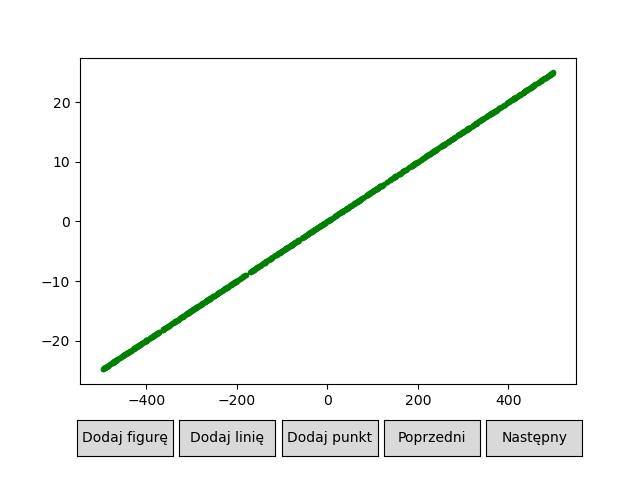

In [14]:
scenes_r=[Scene(i) for i in scenes]
zbiorDsorted=Plot(scenes = scenes_r)
zbiorDsorted.draw()

In [33]:
print(dif)

1564
